<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.3.0
GPU detected: []


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
data = pd.read_csv('data/ner_dataset.csv', encoding='latin1')
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
print("Unique words in corpus: ", data['Word'].nunique())
print("Unique tags in corpus: ", data['Tag'].nunique())

Unique words in corpus:  35178
Unique tags in corpus:  17


<AxesSubplot:xlabel='Tag', ylabel='count'>

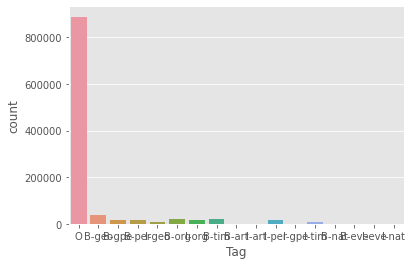

In [4]:
import seaborn as sns
import tkinter
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x='Tag', data=data)

In [5]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [6]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [7]:
num_words, num_tags

(35179, 17)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [8]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                          s["POS"].values.tolist(),
                                                          s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [9]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [10]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [11]:
# enumerate() -> add a counter to an iterable and returns it
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [12]:
tag2idx

{'O': 0,
 'B-per': 1,
 'I-org': 2,
 'B-art': 3,
 'B-nat': 4,
 'I-nat': 5,
 'B-eve': 6,
 'B-geo': 7,
 'I-tim': 8,
 'B-tim': 9,
 'I-gpe': 10,
 'I-eve': 11,
 'B-gpe': 12,
 'I-art': 13,
 'B-org': 14,
 'I-geo': 15,
 'I-per': 16}

### Task 5: Padding Input Sentences and Creating Train/Test Splits

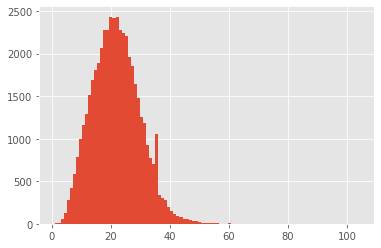

In [13]:
plt.hist([len(s) for s in sentences], bins=100)
plt.show()

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [15]:
X[0]

array([15685, 13411, 21799,  3849, 32085,  8872, 24203, 21539, 33811,
        3076, 10451, 20238, 21459, 19012, 32747,  3076, 10753, 13411,
       13365,  8884,  7081, 23068, 24081, 15507, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178], dtype=int32)

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [17]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [18]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
# SpatialDropout1D -> rather than dropping dropping individual nodes, it drops the entire 1D feature map
model = SpatialDropout1D(0.1)(model)
# Rather than RNN, we are using LSTM to avoid Vanishing Gradient Problem
# using Bi-directional LSTM because, our model can learn from the entire input, rather than just the previous timestamps
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

### Task 7: Train the Model

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKeras
import keras
from keras.models import load_model

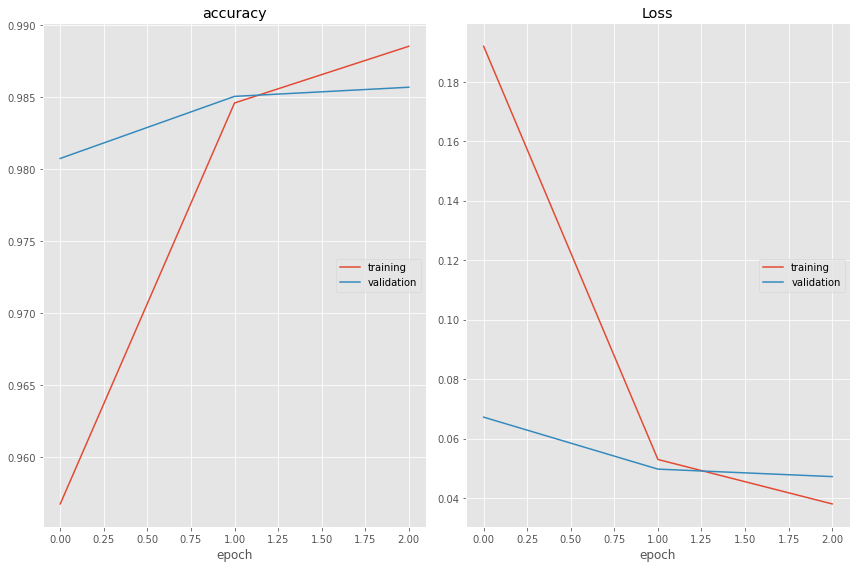

accuracy
	training         	 (min:    0.957, max:    0.989, cur:    0.989)
	validation       	 (min:    0.981, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.038, max:    0.192, cur:    0.038)
	validation       	 (min:    0.047, max:    0.067, cur:    0.047)

Epoch 00003: val_loss improved from 0.04971 to 0.04720, saving model to model_ner.h5
1080/1080 [==============================] - 117s 108ms/step - loss: 0.0380 - accuracy: 0.9885 - val_loss: 0.0472 - val_accuracy: 0.9857


In [21]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)

filename = 'model_ner.h5'
checkpoint = ModelCheckpoint(filename,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

callbacks = [PlotLossesKeras(), early_stopping, checkpoint]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=3,
    verbose=1,
    callbacks=callbacks
)

### Task 8: Evaluate Named Entity Recognition Model

In [22]:
model_ner = load_model("model_ner.h5")

In [23]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 2s 16ms/step - loss: 0.0489 - accuracy: 0.9852


[0.04887985810637474, 0.9851709604263306]

In [24]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("word", "True", "Pred"))
print("-"*30)

idx = 0
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))
    idx += 1
    if idx == 15:
        break

word           True 	 Pred

------------------------------
Nepalese       B-gpe	B-gpe
police         O	O
detained       O	O
41             O	O
Tibetans       B-gpe	B-gpe
Sunday         B-tim	B-tim
for            O	O
illegal        O	O
entry          O	O
into           O	O
the            O	O
country        O	O
.              O	O
meltdown       O	O
meltdown       O	O


In [25]:
def text_process(text):
    seq = []
    for w in text.split():
        try:
            seq.append(word2idx[w])
        except:
            seq.append(num_words-1)

    sz = len(seq)
    print(seq)
    for _ in range(sz, 50):
        seq.append(num_words-1)
    seq = np.array(seq, dtype=int)
    return seq, sz

In [34]:
def get_ner(text):
    seq, sz = text_process(text)
    print(seq)
    p = model_ner.predict(np.array([seq]))
    p = np.argmax(p, axis=-1)

    idx = 0
    for w, pred in zip(seq, p[0]):
        if tags[pred] != 'O':
            print("{:15}\t{}".format(words[w-1], tags[pred]))
        idx += 1
        if idx == sz:
            break

In [35]:
get_ner('Sunday is close day for London .')

[29937, 34677, 12131, 32412, 15555, 24203, 15507]
[29937 34677 12131 32412 15555 24203 15507 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178]
Sunday         	B-tim
London         	B-geo


In [28]:
get_ner('I will go to London from Indonesia Sunday Morning .')

[11968, 24035, 8379, 21539, 24203, 7081, 3455, 29937, 22779, 15507]
London         	B-geo
Indonesia      	B-geo
Sunday         	B-tim
Morning        	I-tim


In [29]:
get_ner('U.S. President George Bush will visit the Vatican city Tomorrow Morning .')

[33999, 32835, 32029, 10789, 24035, 18200, 3076, 32687, 2031, 14807, 22779, 15507]
U.S.           	B-org
President      	B-per
George         	I-per
Bush           	I-per
Tomorrow       	B-org
Morning        	I-org
